In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# 1. Rendering Sentiment Scores Using Previously Trained Model

In [2]:
#Import df with cleaned Steelers tweets
df = pd.read_pickle("game_df_clean.pkl")

#Define a function with additional cleaning steps needed to make Steelers tweets compatible with data that trained the model
def text_cleaner_2(text):
    
    #remove stop words
    stop_words = set(en_stop)
    tokens = word_tokenize(text)
    tokenized = [w for w in tokens if not w in stop_words]
    text = ' '.join(tokenized)
    
    #remove unhelpful words
    unhelpful_words = ['like', 'day', 'time', 'quot', 'day', 'feel', 'today', 'got']
    for word in unhelpful_words:
        text = text.replace(word, '')
    
    #apply stemmer
    s_stemmer = SnowballStemmer(language='english')
    stems=[]
    for word in text.split():
        stm= s_stemmer.stem(word)
        stems.append(stm)
        
        if len(stems) > 2:
            text = ' '.join(stems)
    return text

df['sentiment_text'] = df.sentiment_text.apply(lambda x: text_cleaner_2(x))

#Import trained vectorizer and apply it to Steelers tweets
vectorizer=pickle.load(open('tfidf_vectorizer.sav', 'rb'))
X= vectorizer.transform(df['sentiment_text'])

#Import trained logistic regression model and use it to render sentiment scores
tuned_log_model= pickle.load(open('tuned_log_model.sav', 'rb'))
threshold = .57
X = tuned_log_model.predict_proba(X)[:,1]
df['sentiment'] = ['pos' if i > threshold else 'neg' for i in X]

In [3]:
#Top Ten Features Used by Model for Prediction
coefs = pd.DataFrame(tuned_log_model.coef_, columns= vectorizer.get_feature_names_out()).T
abs(coefs).sort_values(by=0, ascending=False).head(10)

,0
sad,11.884840
miss,7.464209
poor,6.890863
sick,6.203808
depress,5.960013
hurt,5.826666
wish,5.752008
unfortun,5.723859
upset,5.687731
thank,5.627979


# 2. Sentiment of Tweets about the Steelers

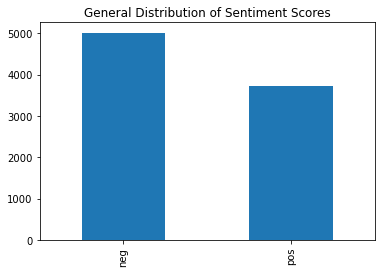

In [4]:
df.sentiment.value_counts().plot.bar(title='General Distribution of Sentiment Scores');

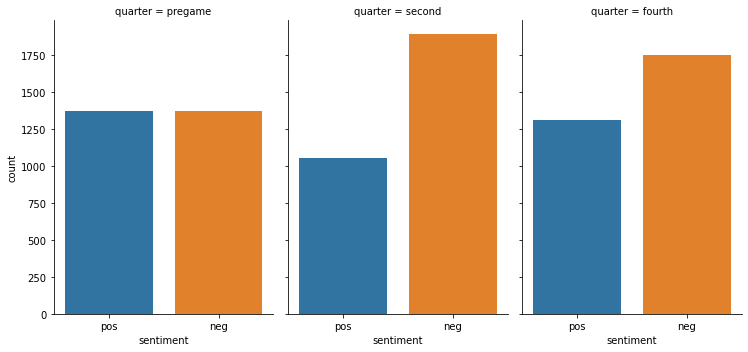

In [5]:
#Sentiment by Quarter
sns.catplot(x="sentiment",
            col='quarter',
            kind="count", data=df,
            aspect=0.7);

In [6]:
#Sentiment by Quarter Counts
df2 = pd.DataFrame(df.groupby(['quarter', 'sentiment']).sentiment.size().values, 
                   index=df.groupby(['quarter', 'sentiment']).sentiment.size().index, 
                   columns=['Count'])
df2=df2.reindex(['pregame', 'second', 'fourth'], level=0)
df2

Count
quarter sentiment       
pregame neg         1371
        pos         1372
second  neg         1891
        pos         1052
fourth  neg         1750
        pos         1309

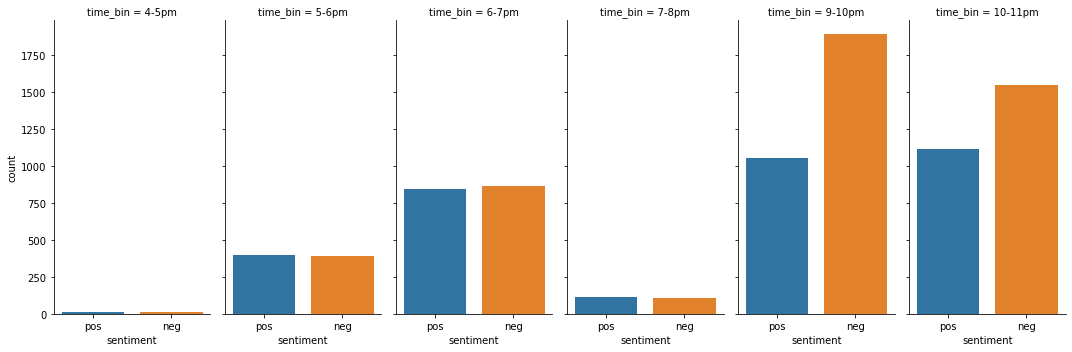

In [7]:
#Breakdown of Sentiment by Hour
df_bins = df.copy()
df_bins['time'] = pd.to_datetime(df_bins['time'], format="%I:%M.%S%p")

bins = [16,17,18,19, 21,22,23]

labels = ['4-5pm','5-6pm','6-7pm','7-8pm','9-10pm','10-11pm']
df_bins['time_bin'] = pd.cut(df_bins.time.dt.hour,bins, labels=labels, right=False)

hour_plot= sns.catplot(x="sentiment",
                                    col='time_bin',
                                    kind="count", 
                                    data=df_bins,
                                    aspect=0.5)
plt.savefig('sentiment_by_hour_plot.png');

C:\Users\karbo\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


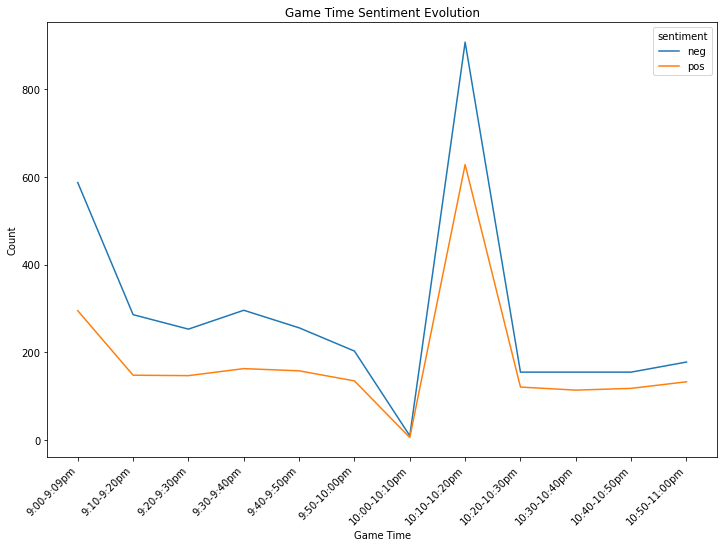

In [8]:
#Sentiment during the Game
df_gametime= df_bins[(df_bins['time_bin'] == '9-10pm') | (df_bins['time_bin'] =='10-11pm')]

#Create bins for (approximately) every ten minutes
labels= ['9:00-9:09pm', '9:10-9:20pm', '9:20-9:30pm', '9:30-9:40pm', '9:40-9:50pm', '9:50-10:00pm',
       '10:00-10:10pm', '10:10-10:20pm', '10:20-10:30pm', '10:30-10:40pm', '10:40-10:50pm', '10:50-11:00pm']

df_gametime.loc[:, 'time_bin2'] = pd.cut(df_gametime.loc[:, 'time'],labels=labels,bins=12,right=False)

game_plot = pd.DataFrame(df_gametime.groupby(['time_bin2', 'sentiment']).sentiment.size().values, 
                         index=df_gametime.groupby(['time_bin2', 'sentiment']).sentiment.size().index, 
                         columns=['Count'])

line, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x= 'time_bin2',
             y= 'Count',
             data=game_plot,
             hue='sentiment',
             ci=None
)
plt.xticks(rotation=45,
          horizontalalignment='right');
plt.title('Game Time Sentiment Evolution')
plt.xlabel('Game Time')
plt.savefig('game_sentiment_evolution.png');

## Observation:
Interestingly, before the game starts there's a nearly equal distribution of positive and negative tweets about the Steelers. However, expectedly, as the game progresses, and the team proceeds to get handily beaten by the Chiefs, we see an increase in negative tweets. During the game itself, positive and negative tweets exhibit a decline proceeding to halftime and then spike around halftime and level off. 

# 3. Sentiment about Big Ben

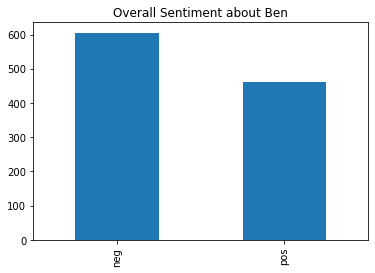

In [9]:
#Filter tweets pertaining to Ben Roethlisberger
df_Ben = df[df['sentiment_text'].str.contains('Ben|ben|Roethlisberger|roethlisberger|Big|big')]

df_Ben.sentiment.value_counts().plot.bar(title='Overall Sentiment about Ben');

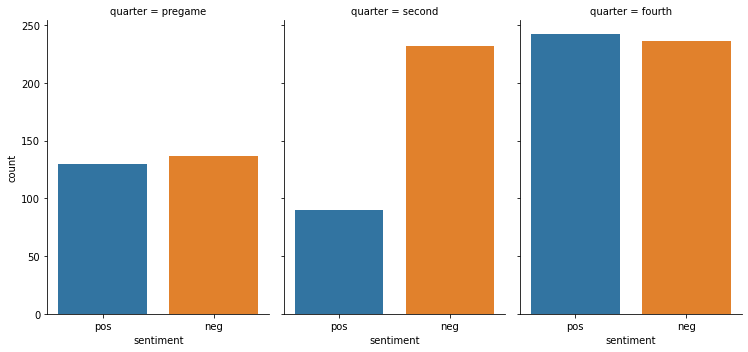

In [10]:
#Breakdown of Sentiment Scores for Ben by Quarter
sns.catplot(x="sentiment",
            col='quarter',
            kind="count", data=df_Ben,
            aspect=0.7);

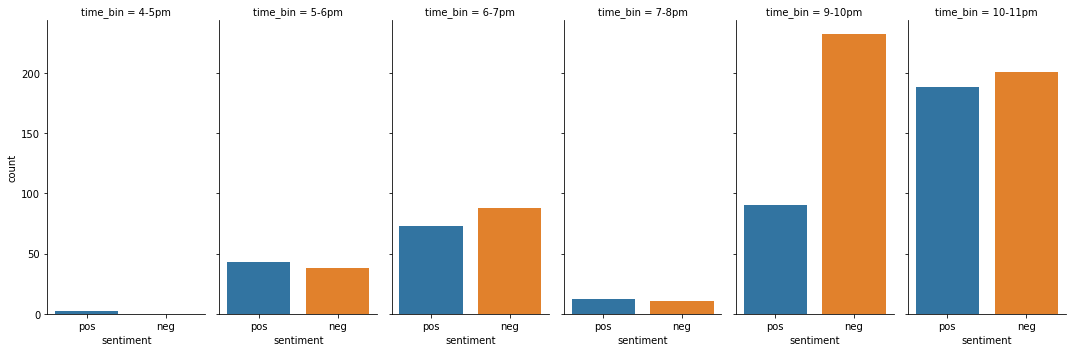

In [11]:
#Breakdown of Sentiment Scores about Ben by the Hour
Ben_tweets=df_bins[df_bins['sentiment_text'].str.contains('Ben|ben|Roethlisberger|roethlisberger|Big|big')]
sns.catplot(x="sentiment",
            col='time_bin',
            kind="count", data=Ben_tweets,
            aspect=0.5)
plt.savefig('Ben_sentiment_by_hour.png');

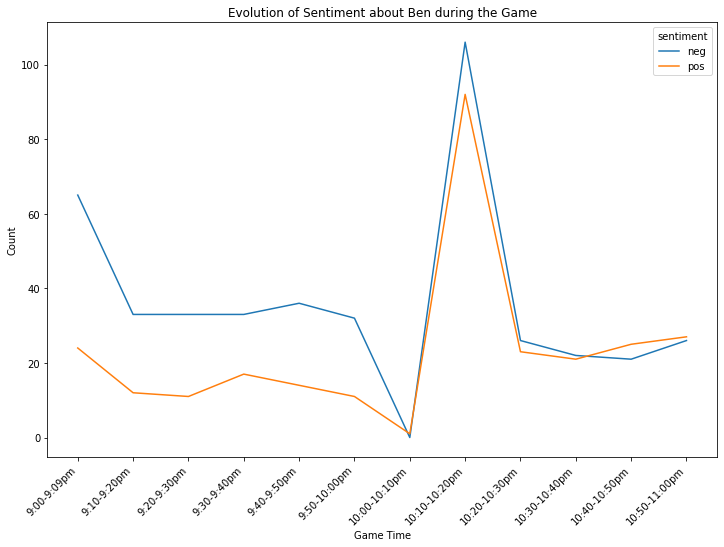

In [12]:
Ben_game_tweets= df_gametime[df_gametime['sentiment_text'].str.contains('Ben|ben|Roethlisberger|roethlisberger|Big|big')]
Ben_game_plot = pd.DataFrame(Ben_game_tweets.groupby(['time_bin2', 'sentiment']).sentiment.size().values, 
                         index=Ben_game_tweets.groupby(['time_bin2', 'sentiment']).sentiment.size().index, 
                         columns=['Count'])

line, ax = plt.subplots(figsize=(12,8))
sns.lineplot( x= 'time_bin2',
             y= 'Count',
             data=Ben_game_plot,
             hue='sentiment',
             ci=None
)
plt.xticks(rotation=45,
          horizontalalignment='right')
plt.xlabel('Game Time')
plt.title('Evolution of Sentiment about Ben during the Game')
plt.savefig('Ben_Game_Sentiment_Evolution.png');

In [13]:
#Top Ten words that appear most frequently in the spike of positive tweets near the end of the game

final_tweets= Ben_game_tweets[(Ben_game_tweets['time_bin2'] == '10:30-10:40pm')|
                              (Ben_game_tweets['time_bin2'] == '10:40-10:50pm')|
                              (Ben_game_tweets['time_bin2'] == '10:50-11:00pm')] 
#Create list of stop words 
stop_words = list(en_stop) + ['ll','ve', 'ben', 'big','big ben', 'steeler', 'roethlisberg']

#Create a document term matrix for the tweets about Ben (including bigrams)
cv = CountVectorizer(stop_words=stop_words, 
                     ngram_range=(1,2))
cv_Ben = cv.fit_transform(final_tweets.sentiment_text)
dtm_Ben = pd.DataFrame(cv_Ben.toarray(), columns=cv.get_feature_names_out())
dtm_Ben= pd.DataFrame(dtm_Ben.sum().values, index=dtm_Ben.sum().index, columns=['count'])
dtm_Ben.sort_values(by='count', ascending=False).head(10)

,count
fan,29
game,26
thank,23
year,23
playoff,18
season,15
watch,14
team,13
qb,12
career,12


## Observation:
Overall, there are more negative than positive tweets pertaining to Ben. The distribution is nearly equal before the game. Then during the second quarter the negative tweets far outpace the positive ones. Interestingly, in the last thirty minutes of the sample time span (near the end of the game) there's a spike in positive tweets. Knowing this to be his last game, otherwise critical Steelers fans are paying homage to him and his career.  